In [1]:
import mesa
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy.integrate import odeint

# ABM model
## Define ABM model 

In [2]:
class SIRAgent(Agent):
    def __init__(self, unique_id, model, initial_state="S"):
        super().__init__(unique_id, model)
        self.state = initial_state
    #Movement function
    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos, moore=True, include_center=False
        )
        new_position = self.random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)
    #SIR contact rule (with probability)
    def contact(self):
        if self.state == "I":
            cellmates = self.model.grid.get_cell_list_contents([self.pos])
            for other in cellmates:
                if (
                    self.random.random() < self.model.infection_probability
                    and other.state == "S"
                ):
                    other.state = "I"

    def step(self):
        if self.state == "I":
            if self.random.random() < self.model.recovery_probability:
                self.state = "R"
        self.move()
        self.contact()

In [3]:
class SIRModel(Model):
    def __init__(self, N, width, height, initial_infected, infection_probability, recovery_probability):
        
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.infection_probability = infection_probability
        self.recovery_probability = recovery_probability

        #Agent creation
        for i in range(self.num_agents):
            if i < initial_infected:
                a = SIRAgent(i, self, initial_state="I")
            else:
                a = SIRAgent(i, self)
            self.schedule.add(a)
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        # DataCollector
        self.datacollector = DataCollector(
            agent_reporters={"State": "state"},
            model_reporters={"S": lambda m: sum(1 for agent in m.schedule.agents if agent.state == "S"),
                            "I": lambda m: sum(1 for agent in m.schedule.agents if agent.state == "I"),
                            "R": lambda m: sum(1 for agent in m.schedule.agents if agent.state == "R")}
        )

    def step(self):
        # Collect data for each step
        self.datacollector.collect(self)
        self.schedule.step()

In [4]:
#Convidence intervale
def get_IC(list, alpha):
    #mean
    mean = np.mean(list, axis=0)
    #std
    std = np.std(list, axis=0)
    
    # Taille de l'échantillon
    len_sample = len(list[0])
    
    # Calculer l'intervalle de confiance à 95%
    IC = stats.norm.interval(alpha, loc=mean, scale=std/np.sqrt(len_sample))

    NaNs_value = np.isnan(IC)
    IC[0][NaNs_value[0]] = mean[NaNs_value[0]]
    IC[1][NaNs_value[1]] = mean[NaNs_value[1]]
    
    return IC,mean

## Parameters

In [5]:
step = 100
N = 997
width = 7
height = 7
initial_infected = 3
infection_probability = 0.06
recovery_probability = 0.04

## Resultats

In [6]:
model = SIRModel(N, width, height, initial_infected, infection_probability, recovery_probability)
for i in range(step):
    model.step()

In [7]:
data = model.datacollector.get_agent_vars_dataframe()

In [8]:
data_for_plot = data.groupby("Step")["State"].value_counts().unstack().fillna(0)
data_for_plot = data_for_plot[["S","I","R"]]

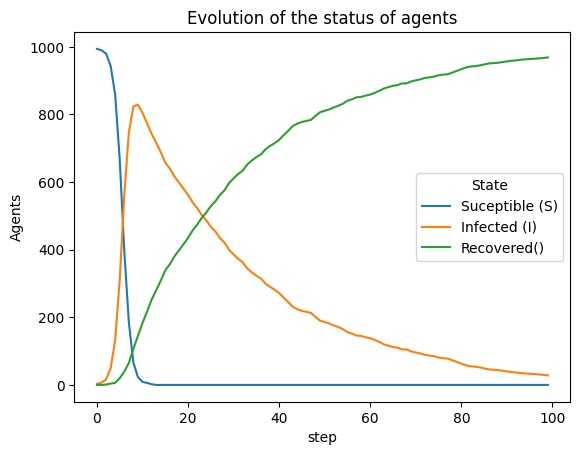

<Figure size 640x480 with 0 Axes>

In [25]:
%matplotlib inline
plt.figure()
plt.plot(np.arange(0, step), data_for_plot)
plt.legend(title='State', labels=['Suceptible (S)','Infected (I)','Recovered()'])
plt.title('Evolution of the status of agents')
plt.xlabel('step')
plt.ylabel('Agents')
plt.show()

## Variability  of the model

In [10]:
S_list =[]
I_list = []
R_list = []
for j in range(10):
    model_1 = SIRModel(N, width, height, initial_infected, infection_probability, recovery_probability)
    for i in range(step):
        model_1.step()
    data_1 = model_1.datacollector.get_agent_vars_dataframe()
    data_for_plot_1 = data_1.groupby("Step")["State"].value_counts().unstack().fillna(0)
    data_for_plot_1 = data_for_plot_1[["S","I","R"]]
    S_list.append(data_for_plot_1["S"])
    I_list.append(data_for_plot_1["I"])
    R_list.append(data_for_plot_1["R"])



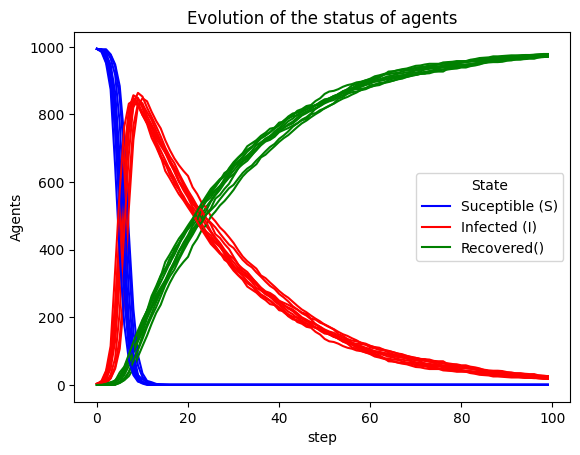

In [28]:
for h in range(10):
    plt.plot(np.arange(0,step),S_list[h],c="b")
    plt.plot(np.arange(0,step),I_list[h],c="r")
    plt.plot(np.arange(0,step),R_list[h],c="g")
    plt.legend(title='State', labels=['Suceptible (S)','Infected (I)','Recovered()'])
    plt.title('Evolution of the status of agents')
    plt.xlabel('step')
    plt.ylabel('Agents')
plt.savefig("ABM Variability")

## IC95

In [12]:
(IC_S,mean_S) = get_IC(S_list,0.9)
(IC_I,mean_I) = get_IC(I_list,0.9)
(IC_R,mean_R) = get_IC(R_list,0.9)

C:\Users\romai\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\romai\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Text(0, 0.5, 'Agents')

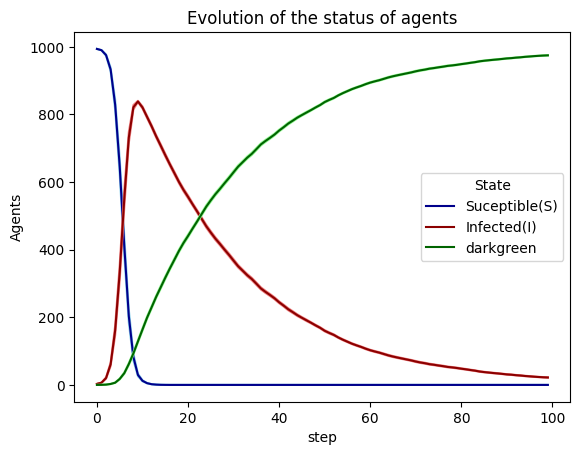

In [13]:
plt.plot(np.arange(0,step),IC_S[0],c="skyblue")
plt.plot(np.arange(0,step),IC_S[1],c="skyblue")
plt.plot(np.arange(0,step),mean_S,c="darkblue",label ="Suceptible(S)")
plt.plot(np.arange(0,step),IC_I[0],c="lightcoral")
plt.plot(np.arange(0,step),IC_I[1],c="lightcoral")
plt.plot(np.arange(0,step),mean_I,c="darkred",label = "Infected(I)")
plt.plot(np.arange(0,step),IC_R[0],c="palegreen")
plt.plot(np.arange(0,step),IC_R[1],c="palegreen")
plt.plot(np.arange(0,step),mean_R,c="darkgreen",label="darkgreen")
plt.legend(title='State')
plt.title('Evolution of the status of agents')
plt.xlabel('step')
plt.ylabel('Agents')

# Mathematical model

$$\begin{cases} S'(t) = - \beta SI\\ I'(t) = \beta SI - \gamma I\\ R'(t) = \gamma I \end{cases}$$
With $\beta$ the infection probability and $\gamma$ the recovery probability 

## Define model

In [14]:
def SIR(X,t):
    
    S = X[0]
    I = X[1]
    R = X[2]
    
    dS = -beta*S*I
    dI = beta*S*I - gamma*I
    dR = gamma*I
    return[dS,dI,dR]

## Parameters

In [19]:
beta = infection_probability
gamma = recovery_probability
#Initial value
X_0 = (997,3,0)
t = np.arange(0,100,1)

## Resultats

In [20]:
Sol = odeint(SIR, X_0, t)

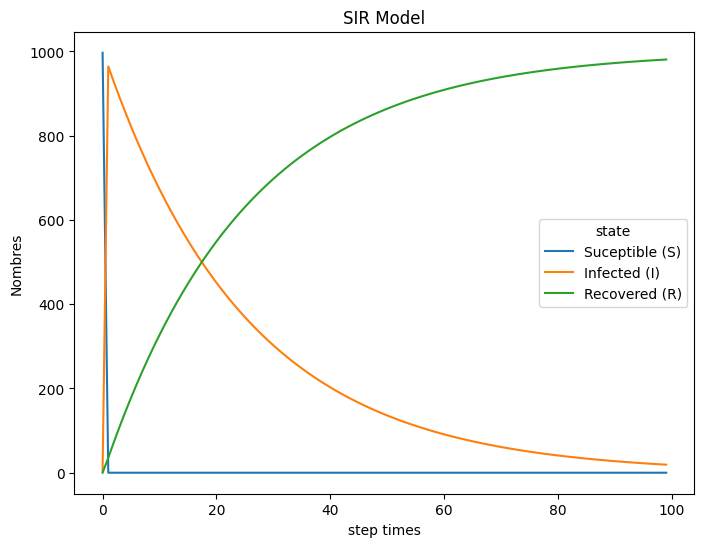

<Figure size 640x480 with 0 Axes>

In [26]:
plt.figure(figsize = (8,6))
plt.plot(t,Sol[:,0],label = "Suceptible (S)")
plt.plot(t,Sol[:,1],label = "Infected (I)")
plt.plot(t,Sol[:,2],label = "Recovered (R)")
plt.title("SIR Model")
plt.xlabel("step times")
plt.ylabel("Nombres")
plt.legend(title ="state")
plt.show()
plt.savefig("SIR_Mathematical_model.png")

# Comparison of the two models

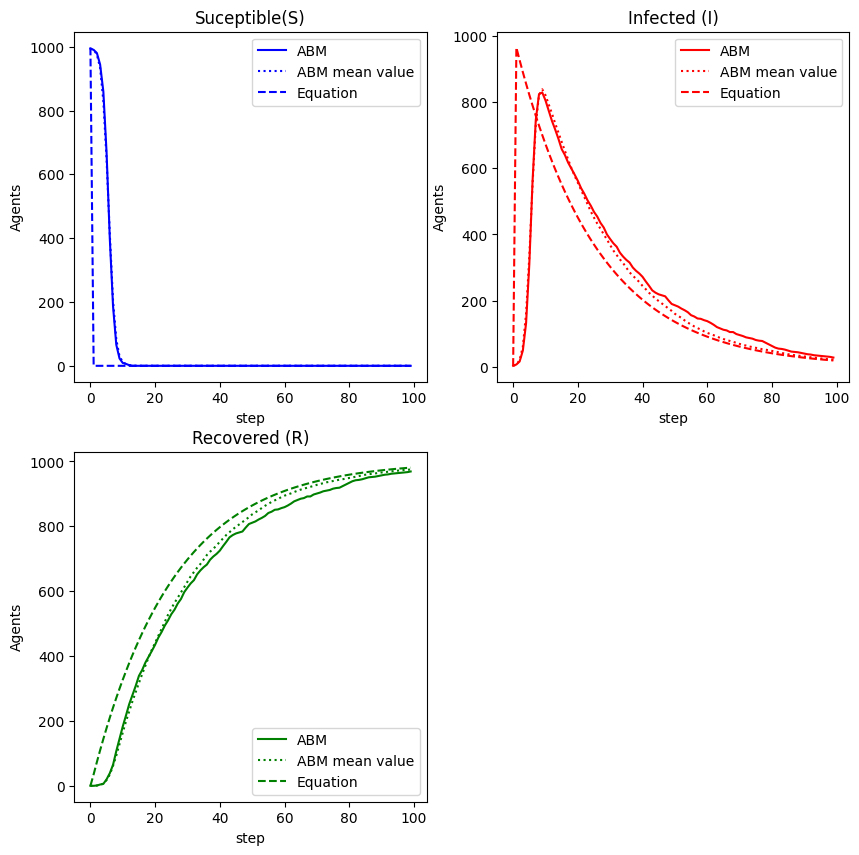

<Figure size 640x480 with 0 Axes>

In [27]:
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.plot(np.arange(0, step), data.groupby("Step")["State"].value_counts().unstack().fillna(0)["S"],label="ABM",c="b")
plt.plot(np.arange(0,step), mean_S, linestyle ="dotted",label = "ABM mean value",c="b")
plt.plot(t,Sol[:,0],linestyle="--",label="Equation",c="b")
plt.legend()
plt.title("Suceptible(S)")
plt.xlabel("step")
plt.ylabel("Agents")

plt.subplot(2,2,2)
plt.plot(np.arange(0, 100), data.groupby("Step")["State"].value_counts().unstack().fillna(0)["I"],label="ABM",c="r")
plt.plot(np.arange(0,step), mean_I, linestyle ="dotted",label = "ABM mean value",c="r")
plt.plot(t,Sol[:,1],linestyle="--",label="Equation",c="r")
plt.legend()
plt.title("Infected (I)")
plt.xlabel("step")
plt.ylabel("Agents")

plt.subplot(2,2,3)
plt.plot(np.arange(0, 100), data.groupby("Step")["State"].value_counts().unstack().fillna(0)["R"],label="ABM",c="g")
plt.plot(np.arange(0,step), mean_R, linestyle ="dotted",label = "ABM mean value",c="g")
plt.plot(t,Sol[:,2],linestyle="--",label="Equation",c="g")
plt.legend()
plt.title("Recovered (R)")
plt.xlabel("step")
plt.ylabel("Agents")


plt.show()
plt.savefig("Comparison.png")